I have identified mouse brain cell type-expressed protein coding genes with pairwise dN/dS calculated from 93 mammalian species against mouse reference genome. Now I want to know which cell types have significantly higher dN/dS. This script calcuated these statistics. 
Debug: Oct 10, 2020: avg_92species, not 93species. 

In [ ]:
import numpy as np
import pandas as pd
import glob

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
pd.set_option('display.max_rows', 10)

# Representitive species pairwise dN/dS against mouse reference genome

In [4]:
from scipy import stats
import heapq

In [5]:
species_list=['human','rat','opposum','megabat','tasmaniandevil','cat','pig','avg_92species'] # debug Oct 10, 2020: 92 species, not 93
celltype_list=['neuron','endothelia','glia','astrocyte','microglia','oligodendrocyte']

### Descriptive Statistics: median and confidence interval

In [6]:
full_dict = {} # This dictionary stores dataframes for later use 
descriptive_stats_df = pd.DataFrame(
    columns=['Species','Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])
for species in species_list:
    full_dict[species] = {}
    for celltype in celltype_list:
        df=pd.read_csv('../results/mouse.celltype-expressed_genes/protein-coding_w_dNdS/'+species+'/'+celltype+'.tsv',
                       index_col=0, sep='\t')
        full_dict[species][celltype]=df
        arr=df.iloc[:,0].dropna().values
        med=np.median(arr)
        low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
        CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
        CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
        descriptive_stats_df = descriptive_stats_df.append(
            {'Species':species,'Celltype':celltype,'Median_dNdS':med,
             'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
            ignore_index=True)


In [7]:
descriptive_stats_df

,Species,Celltype,Median_dNdS,Confidence_Interval_Low,Confidence_Interval_High
0,human,neuron,0.079450,0.077276,0.081683
1,human,endothelia,0.087193,0.084852,0.089626
2,human,glia,0.084516,0.082739,0.086897
3,human,astrocyte,0.084966,0.083002,0.087437
4,human,microglia,0.082118,0.079363,0.083725
...,...,...,...,...,...
43,avg_92species,endothelia,0.095300,0.093438,0.097335
44,avg_92species,glia,0.093110,0.091087,0.094764
45,avg_92species,astrocyte,0.093461,0.091580,0.095165
46,avg_92species,microglia,0.090496,0.088405,0.092480


In [8]:
# create an excel file to write descriptive stats
# future analysis with other reference genome can be added to this as a new tab:

# from openpyxl import load_workbook

# book = load_workbook(path)
# writer = pd.ExcelWriter(path, engine = 'openpyxl') # note the engine
# writer.book = book

# some_df.to_excel(writer, sheet_name = 'some_sheet_name')

# writer.save()
# writer.close()

path = '../results/celltype-expressed_descriptive_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

descriptive_stats_df.to_excel(writer, sheet_name = 'mouse reference genome')

writer.save()
writer.close()


### Inferential statistics: Kruskal Wallis H and Mann Whitney U between celltypes

In [9]:
inferential_stats_df=pd.DataFrame(
    columns=['Species','Kruskal H NEG','Kruskal p NEG',
             'Kruskal H NEAMO','Kruskal p NEAMO',
            'Mann U NG','Mann p NG'])

for species in species_list:

    h_NEG,kp_NEG=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['glia'])

    h_NEAMO,kp_NEAMO=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['astrocyte'],
        full_dict[species]['microglia'],
        full_dict[species]['oligodendrocyte'])
    
    # June 18, 2020: debug on Jan_20_2020-Confirming_w_Couple_Species-Ensembl98Mouse
    # June 24, 2020: debug stats.mannwhitneyu(), include alternative="two-sided", 
    # default "None" is deprecated and generate a smaller p value
    # Now avoid nan values influencing test results.
    # U statistics and p values from Mann Whitney's U test 
    # comparing Neuron-expressed genes and Glia-expressed genes' dN/dS ratios
    u_NG, mp_NG=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['glia'],
        alternative="two-sided")
    
    inferential_stats_df = inferential_stats_df.append(
            {'Species':species,'Kruskal H NEG':h_NEG,'Kruskal p NEG':kp_NEG,
            'Kruskal H NEAMO':h_NEAMO,'Kruskal p NEAMO':kp_NEAMO,
            'Mann U NG':u_NG,'Mann p NG':mp_NG},
            ignore_index=True)

In [10]:
# Create and write to excel file for inferential stats
path = '../results/celltype-expressed_inferential_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

inferential_stats_df.to_excel(writer, sheet_name = 'mouse reference genome')

writer.save()
writer.close()

# Visualization

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import seaborn as sns

In [53]:
matplotlib.rcParams['figure.dpi']= 600

In [13]:
from copy import deepcopy

In [14]:
from matplotlib.ticker import LogLocator, AutoLocator

In [44]:
# for bar graphs to work with log scale, drop dN/dS values that equal to zero
no_zero_dict={}
for species in full_dict:
    no_zero_dict[species]={}
    for celltype in full_dict[species]:
        df=full_dict[species][celltype]
        no_zero_df=df[(df != 0).any(axis=1)]
        no_zero_dict[species][celltype]=no_zero_df

In [47]:
graph_dict = deepcopy(no_zero_dict)
graph_df = pd.DataFrame(columns=['dNdS','Species','Celltype'])
for celltype in celltype_list:
    for species in species_list:
        graph_dict[species][celltype].columns=['dNdS']
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Species=species)
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Celltype=celltype)
        graph_df=graph_df.append(graph_dict[species][celltype][['dNdS','Species','Celltype']],ignore_index=True)

In [48]:
sns.set_style('ticks')

In [49]:
palette={'endothelia':'tab:blue','glia':'tab:green','neuron':'tab:red','oligodendrocyte':'lightblue','astrocyte':'lightgreen','microglia':'tab:orange'}

In [50]:
for species in species_list:
    data=graph_df[graph_df['Species']==species]
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot()
    ax = sns.boxplot(y="dNdS", x="Celltype", data=data,showfliers=False,palette=palette)
    ax.set_yscale('log')
    ax.set_ylim(0.0005,1)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    sns.despine()
    stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",
                        box_pairs=[("endothelia", "neuron"),
                                   ("endothelia", "glia"),
                                   ("glia","neuron"),
                                   ("astrocyte","neuron"),
                                   ("microglia","neuron"),
                                   ("oligodendrocyte","neuron"),
                                   ("astrocyte","microglia"),
                                   ("microglia","oligodendrocyte"),
                                   ("astrocyte","oligodendrocyte")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
    pd.DataFrame(stats[1]).to_csv('../results/mouse.celltype-expressed_genes/protein-coding_w_dNdS/MannWhitney/'+species+'.tsv',sep='\t',index=False)
    ax.set_xlabel("Cell Types")
    ax.set_ylabel("dN/dS of Cell Type-expressed Genes")
    plt.savefig('../figures/MannWhitney/mouse_reference_genome/'+species+'.celltype-expressed.pdf')
    plt.close()

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.434e-07 U_stat=3.368e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.697e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.879e-01 U_stat=3.259e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.274e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.743e-04 U_stat=3.964e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.022e-01 U_stat=3.860e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.762e-07 U_stat=3.098e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.414e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.974e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.041e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.893e-04 U_stat=3.626e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.315e-01 U_stat=3.527e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.184e-04 U_stat=2.661e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.876e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.772e-02 U_stat=2.550e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.515e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.005e-01 U_stat=3.112e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.402e-01 U_stat=2.976e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.250e-02 U_stat=9.369e+06
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.017e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.064e+06
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.167e+06
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.959e-02 U_stat=1.080e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.985e-01 U_stat=1.054e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.900e-04 U_stat=2.468e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.685e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.901e-02 U_stat=2.383e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.357e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.984e-02 U_stat=2.874e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.524e-01 U_stat=2.762e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.191e-07 U_stat=3.189e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.495e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.825e-01 U_stat=3.079e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.104e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.367e-04 U_stat=3.738e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.219e-01 U_stat=3.634e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.188e-07 U_stat=3.151e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.464e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.106e-01 U_stat=3.051e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.089e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.512e-04 U_stat=3.704e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.949e-01 U_stat=3.610e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.737e-09 U_stat=4.259e+07
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.272e-01 U_stat=4.713e+07
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.487e-01 U_stat=4.143e+07
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.200e+07
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.161e-05 U_stat=4.991e+07
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.178e-02 U_stat=4.865e+07
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=

Text(0.5, 197.41666666666669, 'Cell Types')

Text(248.18778025309243, 0.5, 'dN/dS of Cell Type-expressed Genes')

[None]

(0.0005, 0.5)

[Text(0, 0, 'human'),
 Text(0, 0, 'rat'),
 Text(0, 0, 'opposum'),
 Text(0, 0, 'megabat'),
 Text(0, 0, 'tasmaniandevil'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'pig'),
 Text(0, 0, 'avg_92species')]

Text(0.5, 0, 'Species compared against mouse reference genome')

Text(0, 0.5, 'dN/dS of Cell Type-expressed Genes')

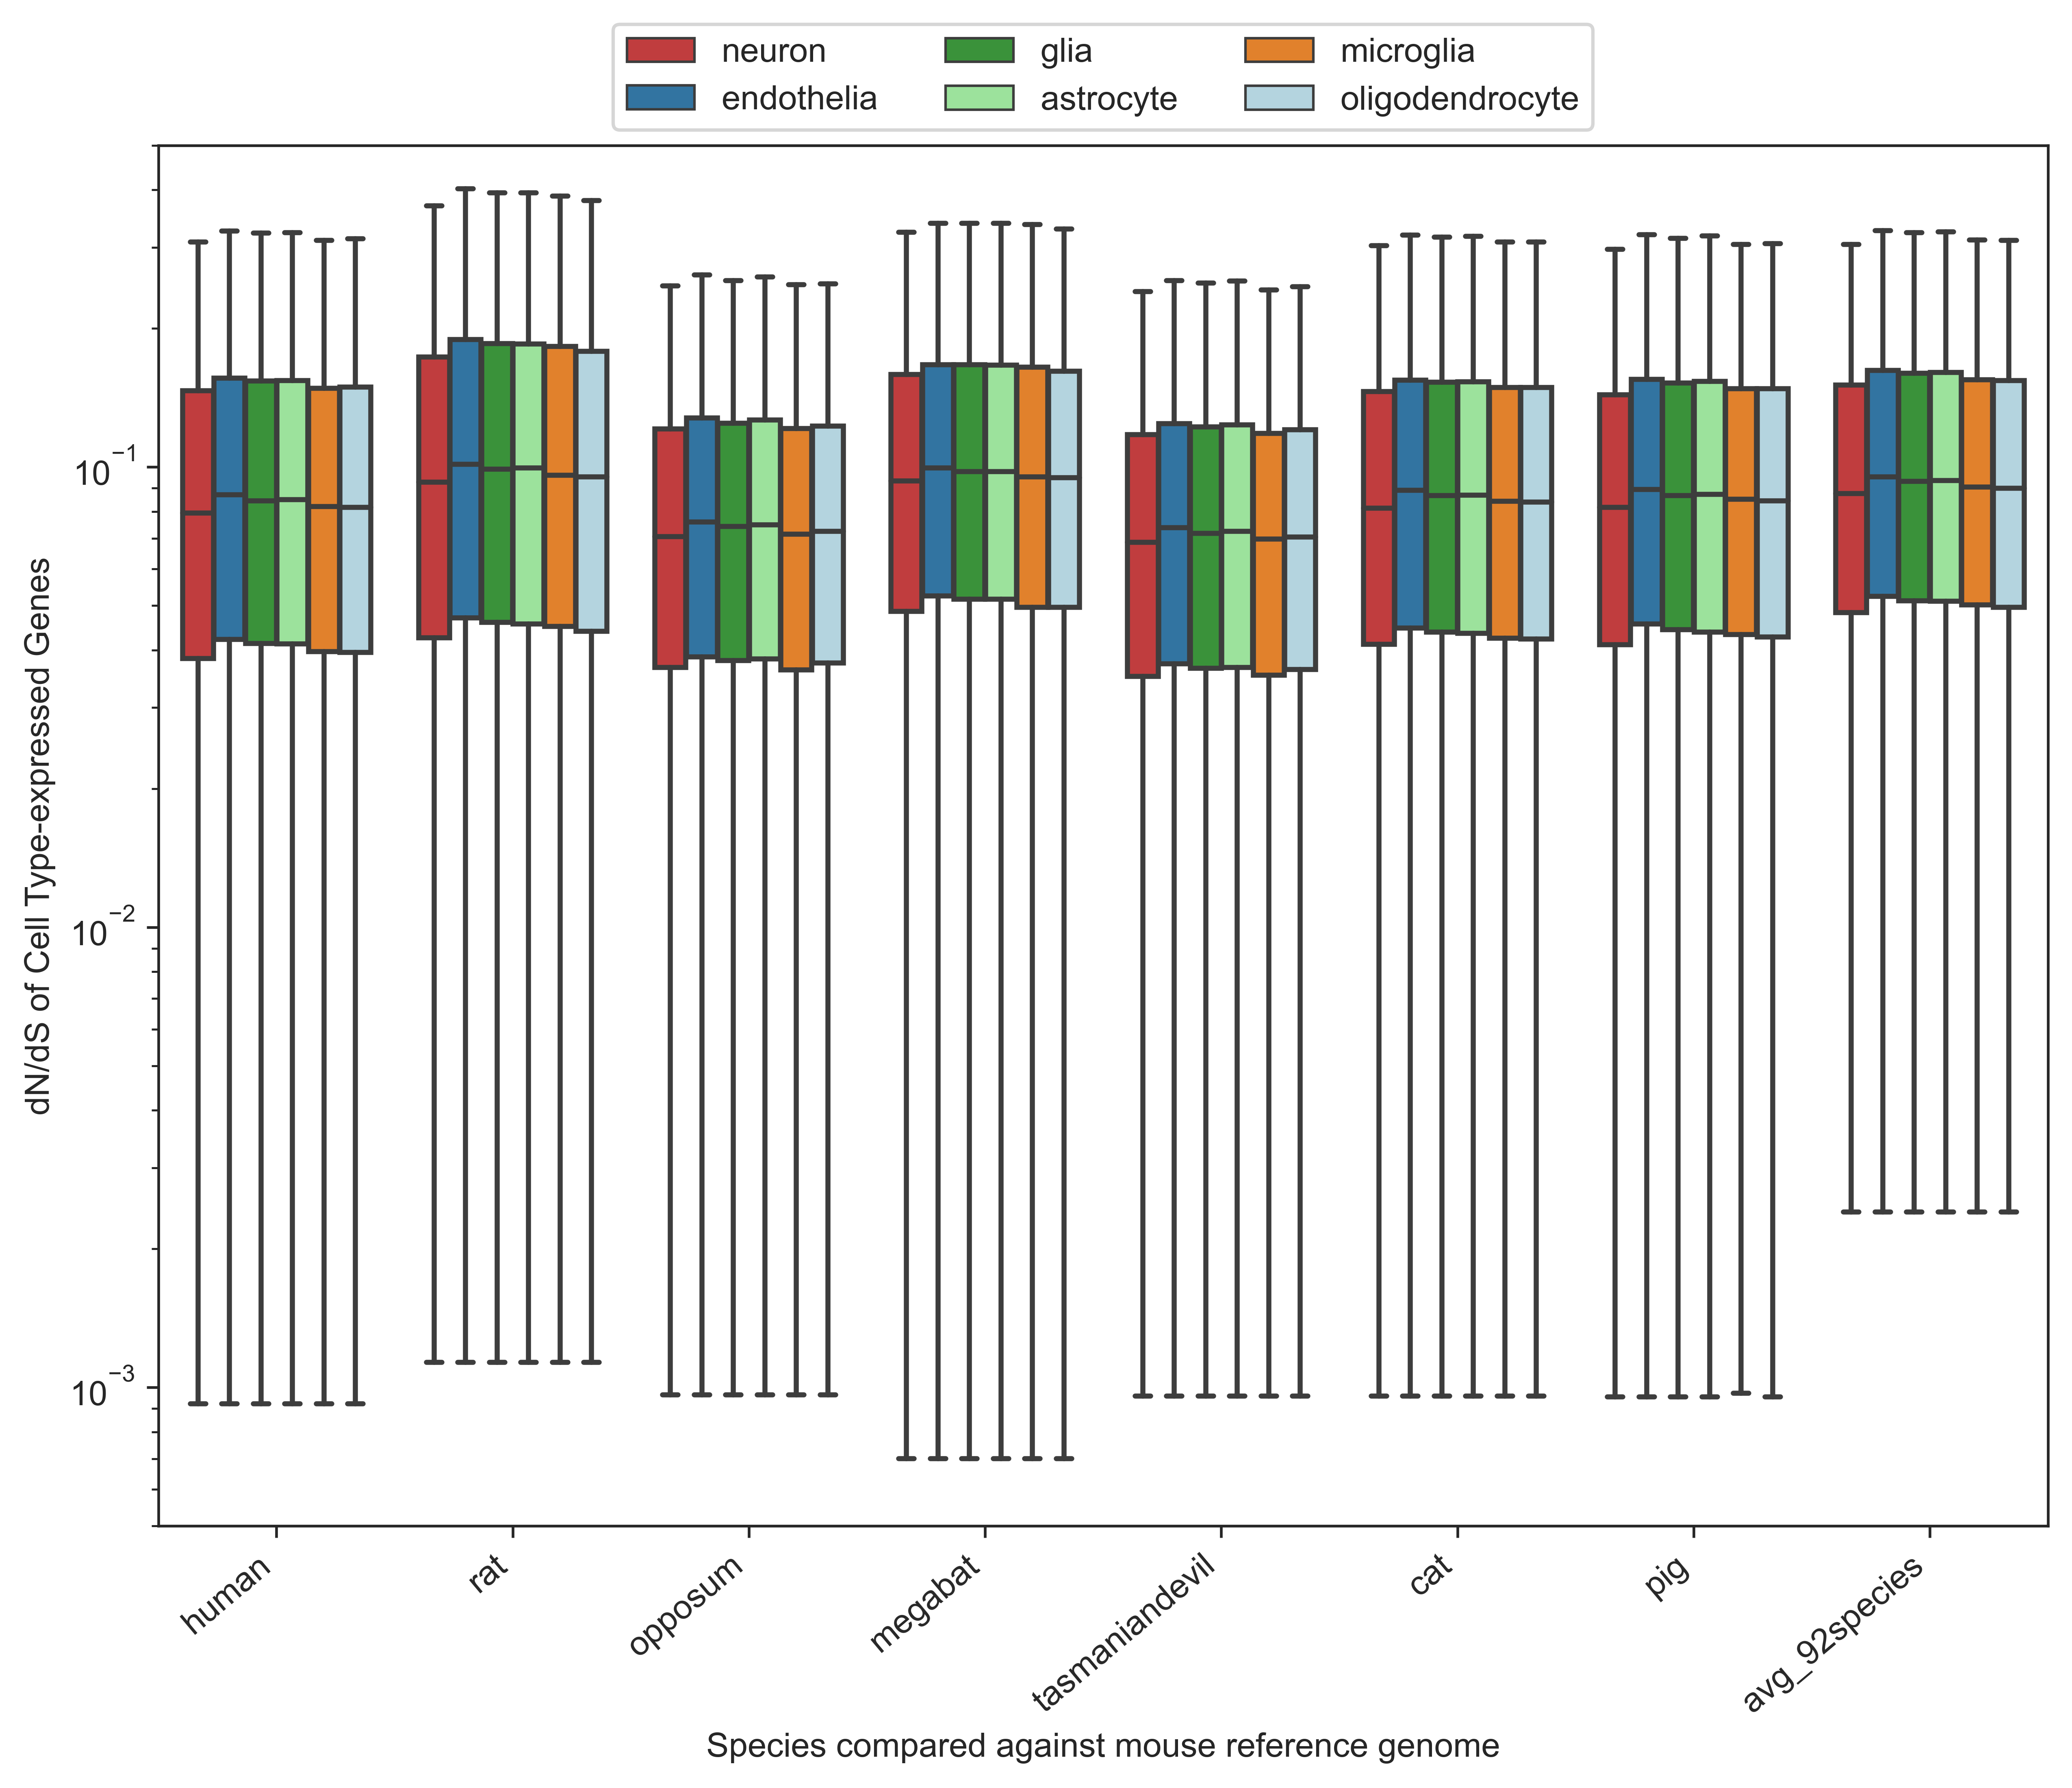

In [54]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
ax = sns.boxplot(x="Species", y="dNdS", hue="Celltype", data=graph_df, showfliers=False, palette=palette)
ax.set(yscale='log')
ax.set_ylim(0.0005,0.5)
# ax.set_yscale('symlog', linthreshy=0.05)
# ax.yaxis.set_minor_locator(LogLocator(subs=np.arange(2, 10)))
# ax.minorticks_on()
# locmaj = matplotlib.ticker.LogLocator(base=10,numticks=1) 
# ax.yaxis.set_major_locator(locmaj)
# locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# ax.set_ylim(0.00001,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.1),ncol=3)
ax.set_xlabel("Species compared against mouse reference genome")
ax.set_ylabel("dN/dS of Cell Type-expressed Genes")
plt.savefig('../figures/mouse.celltype-expressed.boxplots.pdf')
plt.show()